In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import dotenv
import requests
from requests.auth import HTTPBasicAuth
import os

plt.rcParams["font.family"] = "Arial"
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 12
plt.rcParams["ytick.major.size"] = 12
plt.rcParams["xtick.major.pad"] = 18
plt.rcParams["ytick.major.pad"] = 18
plt.rcParams['axes.linewidth'] = 1.0

dotenv.load_dotenv()

True

In [2]:
star = pd.read_csv("user_info_1.csv")
star.head()

,username,star,created_at,updated_at,elapsed_time,star_per_day,star_per_day_biased,issue_count,issue_per_day_biased
0,collymore,8,2009-02-19 16:16:06,2020-09-26 11:37:56,4236,0.001889,0.001889,7,0.001653
1,sujanucsc,9,2009-03-12 16:20:20,2020-08-16 18:30:00,4175,0.002156,0.002156,0,0.000000
2,Theorem,0,2018-03-15 21:04:11,2020-07-28 05:07:27,865,0.000000,0.000000,0,0.000000
3,mussawir20,1,2009-05-03 00:01:17,2020-09-18 14:41:17,4156,0.000241,0.000241,0,0.000000
4,bytheway,958,2008-04-04 17:43:29,2020-09-24 13:30:55,4555,0.210318,0.210318,11,0.002415


In [16]:
created_at = []
updated_at = []

for i in range(len(star)):
    created_at.append(datetime.strptime(star["created_at"][i], "%Y-%m-%dT%H:%M:%SZ"))
    updated_at.append(datetime.strptime(star["updated_at"][i], "%Y-%m-%dT%H:%M:%SZ"))

In [18]:
star["created_at"] = created_at
star["updated_at"] = updated_at

In [32]:
auth = HTTPBasicAuth(
    os.environ.get("GITHUB_USERNAME"), os.environ.get("GITHUB_TOKEN")
)

for i in range(len(star)):
    if star.star[i] == 100:
        page = 1
        cnt = 0
        while True:
            data = requests.get(
                f"https://api.github.com/users/{star.username[i]}/starred?per_page=100&page={page}",
                auth=auth
            ).json()
            
            if len(data) == 0:
                break
            
            cnt += len(data)
            page += 1
        
        star.star[i] = cnt

<ipython-input-32-036830168289>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star.star[i] = cnt


In [34]:
star.to_csv("user_info_1.csv", index=False)

In [291]:
star.head()

,username,star,created_at,updated_at,elapsed_time,star_per_day,star_per_day_biased
0,collymore,8,2009-02-19 16:16:06,2020-09-26 11:37:56,4237,0.001888,0.001888
1,sujanucsc,9,2009-03-12 16:20:20,2020-08-16 18:30:00,4176,0.002155,0.002155
2,Theorem,0,2018-03-15 21:04:11,2020-07-28 05:07:27,866,0.000000,0.000000
3,mussawir20,1,2009-05-03 00:01:17,2020-09-18 14:41:17,4157,0.000241,0.000241
4,bytheway,958,2008-04-04 17:43:29,2020-09-24 13:30:55,4556,0.210272,0.210272


In [258]:
to_day = lambda x: x.days + 1
star["elapsed_time"] = (star.updated_at - star.created_at).apply(to_day)

In [267]:
star[705:710]

,username,star,created_at,updated_at,elapsed_time,star_per_day,star_per_day_biased
705,verky,1,2009-07-21 12:30:36,2020-08-05 20:56:47,4034,0.000248,0.000248
706,uncertainprogress,5,2008-08-11 17:33:00,2017-08-15 06:19:45,3291,0.001520,0.001519
707,Deniz,2,2009-01-14 07:53:04,2020-09-25 15:27:21,4273,0.000468,0.000468
708,mengxianchao,2,2009-07-30 15:13:43,2019-12-18 12:23:39,3793,0.000527,0.000527
709,create-dmg,0,2020-05-21 16:35:32,2020-05-21 16:37:02,1,NaN,0.000000


In [268]:
star["star_per_day"] = star["star"] / star["elapsed_time"]

In [269]:
def func(x):
    bias = 0 if x.elapsed_time > 1000 else 1000
    
    return x.star / (bias + x.elapsed_time)

star["star_per_day_biased"] = star.apply(func, axis=1)

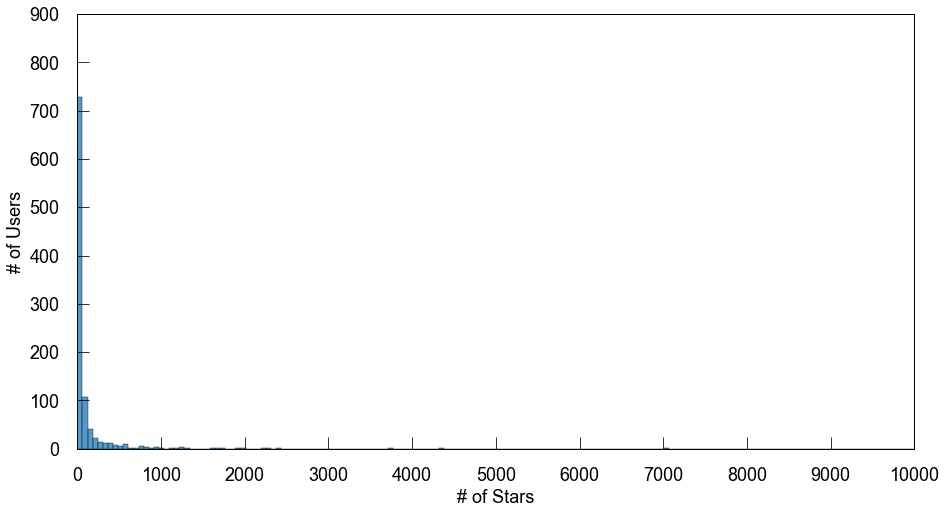

In [12]:
plt.figure(figsize=(15,8))
sns.histplot(star.star, bins=200)
plt.xticks([1000*i for i in range(11)])
plt.xlim(0, 10000)
plt.ylim(0, 900)
plt.xlabel("# of Stars", fontsize=18)
plt.ylabel("# of Users", fontsize=18)
plt.savefig("./star_per_day.svg", transparent=True)
plt.show()

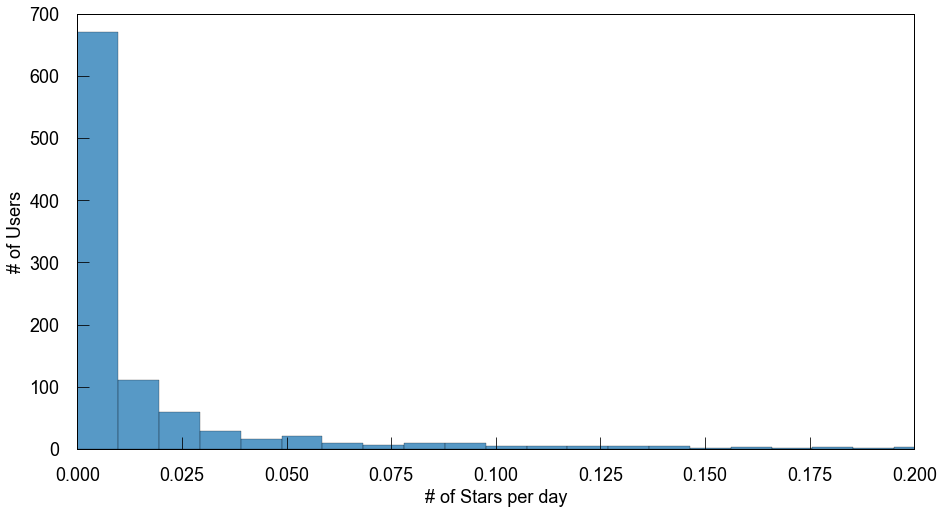

In [24]:
plt.figure(figsize=(15,8))
sns.histplot(star.star_per_day_biased, bins=300)
plt.xlabel("# of Stars per day", fontsize=18)
plt.ylabel("# of Users", fontsize=18)
plt.xlim(0, 0.2)
plt.ylim(0, 700)
plt.savefig("./star_per_day.svg", transparent=True)
plt.show()

In [290]:
print(f"Stdev biased: {stats.tstd(star.star_per_day_biased):.4}")
print(f"Mean: {star.star_per_day_biased.mean():.4}")
print(f"Median: {star.star_per_day_biased.median():.4}")

Stdev biased: 0.1257
Mean: 0.02862
Median: 0.002706


In [282]:
def hensati(x):
    return (x - 0.02862) / 0.1257 * 10 + 50

In [292]:
hensati(0.21)

64.42959427207637

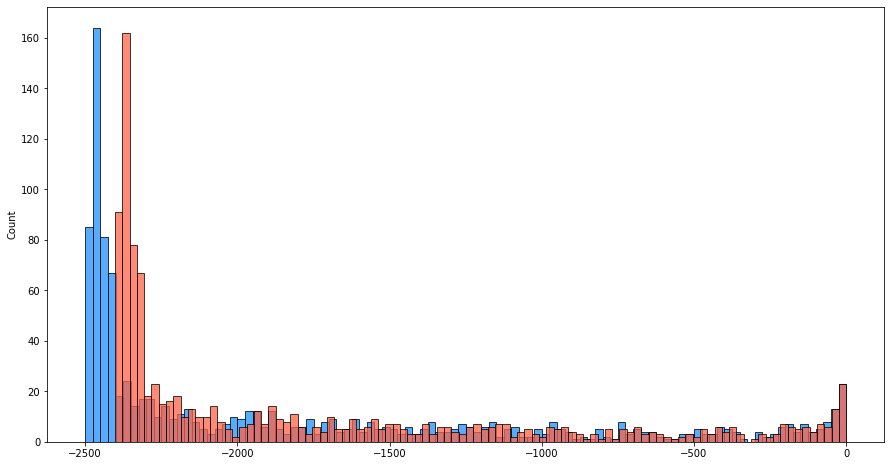

In [214]:
from scipy import stats

c = 0.1
plt.figure(figsize=(15,8))
sns.histplot(stats.boxcox(star.star_per_day + c, lmbda=-4), bins=100, color="dodgerblue")
sns.histplot(stats.boxcox(star.star_per_day + c + 0.001, lmbda=-4), bins=100, color="tomato")
#plt.xlim(-0.02, 4)
#plt.ylim(0, 60)
plt.show()

In [233]:
star.to_csv("user_info_1.csv", index=False)

GitHub アカウントを作って時間が経ってない人は少しスターをつける数が増えるだけで１日あたりのスター数が急激に増えて`log10(10*x + 1)` が一気に増えてしまう。

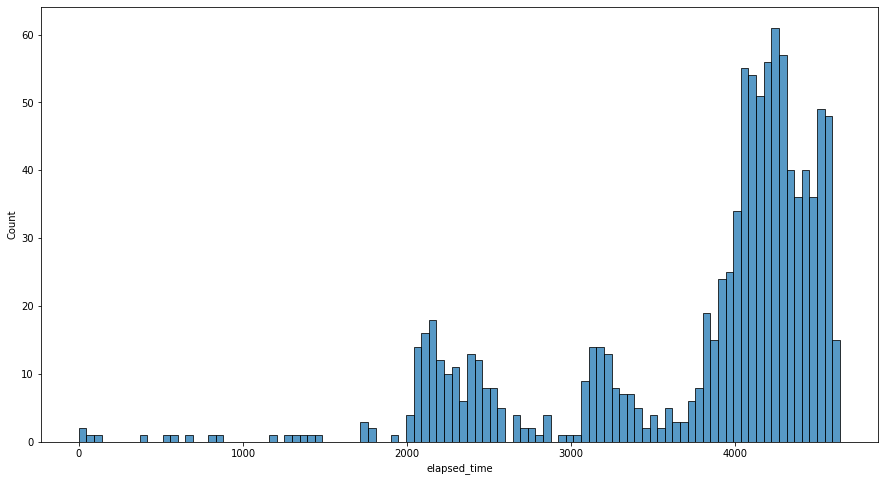

In [167]:
plt.figure(figsize=(15,8))
sns.histplot(star.elapsed_time, bins=100)
plt.show()